In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import train_test_split

In [2]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
df = X.join(y)
df.head()

,engine,max_power,mileage,km_driven,selling_price
0,1248.0,74.00,23.40,145500,450000
1,1498.0,103.52,21.14,120000,370000
2,1497.0,78.00,17.70,140000,158000
3,1396.0,90.00,23.00,127000,225000
4,1298.0,88.20,16.10,120000,130000


In [3]:
df.isnull().sum()

engine           214
max_power        208
mileage          214
km_driven          0
selling_price      0
dtype: int64

In [4]:
df.dropna(inplace=True)
df.isna().sum()

engine           0
max_power        0
mileage          0
km_driven        0
selling_price    0
dtype: int64

In [5]:
df.dtypes

engine           float64
max_power        float64
mileage          float64
km_driven          int64
selling_price      int64
dtype: object

In [6]:

# X = pd.read_csv('X.csv')
# y = pd.read_csv('y.csv')
X = df[['engine','max_power','mileage','km_driven']]
y = df['selling_price']

print(y.max())
print(y.min())



10000000
29999


In [46]:

#max_val, min_val = y.max(), y.min()
max_val, min_val = 1000000, 29999

n_bins = 4
bin_width = (max_val - min_val) / n_bins
bin_edges = [min_val + i * bin_width for i in range(n_bins + 1)]
bin_labels = [0, 1, 2, 3]
y = pd.cut(y, bins=bin_edges, labels=bin_labels, include_lowest=True)




In [47]:
bin_edges

[29999.0, 272499.25, 514999.5, 757499.75, 1000000.0]

In [8]:


X = X.fillna(X.mean())
X = X[~y.isna()]
y = y.dropna()


In [9]:
y.unique()

[1, 0, 3, 2]
Categories (4, int64): [0 < 1 < 2 < 3]

In [10]:
set(y)

{0, 1, 2, 3}

In [11]:
y.shape,X.shape

((7000,), (7000, 4))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42 )
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(5250, 4) (1750, 4) (5250,) (1750,)


In [13]:

# y = y.drop(['selling_price'], axis=1)
# X = X[~y['price_bucket'].isna()]
# y = y['price_bucket'].dropna()


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# intercept = np.ones((X_train.shape[0], 1))
# X_train   = np.concatenate((intercept, X_train), axis=1)
# intercept = np.ones((X_test.shape[0], 1))
# X_test    = np.concatenate((intercept, X_test), axis=1)

k = len(set(y))
m = X_train.shape[0]
n = X_train.shape[1]
Y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = y_train==each_class
    Y_train_encoded[np.where(cond), each_class] = 1

y_train = pd.to_numeric(y_train)

y_test = pd.to_numeric(y_test)

In [14]:
import pickle
model_pkl_file = "a3_scaler.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(scaler, file)

In [15]:
y_test.shape

(1750,)

In [16]:
y_train.shape

(5250,)

In [17]:
X_train.shape

(5250, 4)

In [18]:
X.columns


Index(['engine', 'max_power', 'mileage', 'km_driven'], dtype='object')

In [19]:
X_train.shape

(5250, 4)

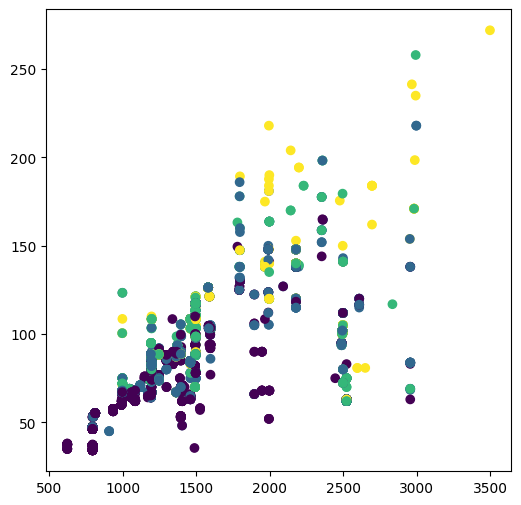

In [20]:
# Visualize our data
plt.figure(figsize=(6,6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], label='class 0', c=y)
plt.show()

In [26]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.


#HERE, we write the code to access the mlflow server in order to save our models

# mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_tracking_uri("http://localhost:8080")


# os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
# os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"

os.environ["LOGNAME"] = "sixth try exp 3"

# mlflow.set_experiment(experiment_name="st125002-a3")

In [27]:
np.array(y_test)[1]

1

In [28]:
yhat[1]

NameError: name 'yhat' is not defined

In [21]:
def accuracy_score(y_test, yhat):
    correct=0
    for i in range(len(yhat)):
        if np.array(y_test)[i] == yhat[i]:
            correct+=1
    return correct/len(y_test)

In [29]:

# Function to compute precision, recall and f1-score for one class
def class_metrics(y_test, yhat, cls):
    # True Positives (TP): correct prediction for class cls
    tp = sum((yhat == cls) & (y_test == cls))
    # False Positives (FP): predicted class cls but actually another class
    fp = sum((yhat == cls) & (y_test != cls))
    # False Negatives (FN): didn't predict class cls but it was actually cls
    fn = sum((yhat != cls) & (y_test == cls))
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1 score: 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Function to calculate macro-averaged metrics
def macro_metrics(y_test, yhat, num_classes):
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    
    for cls in range(num_classes):
        precision, recall, f1 = class_metrics(np.array(y_test), np.array(yhat), cls)
        total_precision += precision
        total_recall += recall
        total_f1 += f1
    
    # Macro average is the mean of the metrics for all classes
    macro_precision = total_precision / num_classes
    macro_recall = total_recall / num_classes
    macro_f1 = total_f1 / num_classes
    
    return macro_precision, macro_recall, macro_f1

# Function to calculate class weights (frequency of each class in y_test)
def class_weights(y_test, num_classes):
    class_counts = np.bincount(y_test)
    total_samples = len(y_test)
    weights = class_counts / total_samples
    return weights

# Function to calculate weighted-averaged metrics
def weighted_metrics(y_test, yhat, num_classes):
    weights = class_weights(np.array(y_test), num_classes)
    total_weighted_precision = 0
    total_weighted_recall = 0
    total_weighted_f1 = 0
    
    for cls in range(num_classes):
        precision, recall, f1 = class_metrics(np.array(y_test), np.array(yhat), cls)
        weight = weights[cls]
        total_weighted_precision += precision * weight
        total_weighted_recall += recall * weight
        total_weighted_f1 += f1 * weight
    
    return total_weighted_precision, total_weighted_recall, total_weighted_f1


In [30]:
class LogisticRegression:

    def __init__(self, k, n, method, alpha = 0.0001, max_iter=5000, ridge=False, lmbda=0.1):
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
        self.ridge = ridge
        self.lmbda = lmbda

    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k) * 0.01
        self.losses = []

        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
                
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0])
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)

                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
                
            print(f"time taken: {time.time() - start_time}")

        elif self.method == "sto":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad

                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")

        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')


    def gradient(self, X, Y):
        m = X.shape[0]
        H = self._predict(X, self.W)
        loss = -np.sum(Y*np.log(H)) / m
        grad = X.T @ (H - Y)

        # If ridge (L2 penalty) is enabled, modify the loss and gradient
        if self.ridge:
            # Add L2 penalty to the loss
            loss += (self.lmbda / (2 * m)) * np.sum(np.square(self.W))
            # Add L2 penalty to the gradient
            grad += (self.lmbda / m) * self.W

        return loss, grad

        return loss, grad
    
    def _predict(self, X, W):
        return self.softmax(X @ W)
    
    def softmax(self, theta_t_x):
        # theta_t_x[theta_t_x == 0] = 0.0001
        # print("softmax value:",np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True))
        # print()
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        # error[error == 0] = 0.0001
        return  X.T @ error

    def h_theta(self, X, W):
        # W[W == 0] = 0.0001
        # print("self.softmax in h_theta:",self.softmax(X@W))
        return self.softmax(X @ W)

    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)

    def plot(self, pen):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()
        plot_save = f"grad_ride_{pen}.png"  # Use the format you specified
        plt.savefig(plot_save)
        plt.close()  # Close the plot to free up memory
        
        return plot_save
        



In [31]:
np.unique(Y_train_encoded)

array([0., 1.])

In [32]:
gradiant = ['sto', 'minibatch', 'batch']
ridge_penalty = [True, False]
best_accuracy = float('-inf')
best_params = {}
best_model = None
# with mlflow.start_run(run_name=f"{reg_method}_{batch_method}_{init_method}_lr{lr}_momentum{use_momentum}", nested=True):
for grad in gradiant: 
    for pen in ridge_penalty:

        with mlflow.start_run(run_name=f"{grad}_ridge:{pen}", nested=True):
            print(f"Running: {grad}_ridge:{pen}")
                        
            model = LogisticRegression(k, X_train.shape[1], method=grad, ridge=pen, lmbda=0.1)
            params = {
                                "method": grad, 
                                "lr":0.01,
                                "l": 0.1,
                                "ridge penalty":pen
                            }
            model.fit(X_train, Y_train_encoded)
            mlflow.log_params(params)
            yhat = model.predict(X_test)
            precision, recall, f1_score = class_metrics(y_test, yhat, k)

            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1_score)


            
            # Calculate macro-averaged metrics
            macro_precision, macro_recall, macro_f1 = macro_metrics(y_test, yhat, k)
            mlflow.log_metric("macro_precison", macro_precision)
            mlflow.log_metric("macro_recall", macro_recall)
            mlflow.log_metric("macro_f1", macro_f1)

            weighted_precision, weighted_recall, weighted_f1 = weighted_metrics(y_test, yhat, k)
            mlflow.log_metric("weighted_precision", weighted_precision)
            mlflow.log_metric("weighted_recall", weighted_recall)
            mlflow.log_metric("weighted_f1", weighted_f1)
            
            accuracy = accuracy_score(y_test, yhat)                            # Log model
            signature = mlflow.models.infer_signature(X_train, model.predict(X_test))
            mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

            # Calculate weighted-averaged metrics
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_params = {
                    "gradiant": grad,
                    "Ridge": pen
                    }
                
            plt_file_path = model.plot(pen)  # Generate and save the plot
    
    # Log the plot file to MLflow
            mlflow.log_artifact(plt_file_path)
            
            mlflow.end_run()

Running: sto_ridge:True
Loss at iteration 0 1.388430938039162
Loss at iteration 500 1.3641028965012978
Loss at iteration 1000 1.3925829356571435
Loss at iteration 1500 1.3841383015633233
Loss at iteration 2000 1.352352758517767
Loss at iteration 2500 1.3748673099627935
Loss at iteration 3000 1.211200457350773
Loss at iteration 3500 1.4520724977371797
Loss at iteration 4000 1.289162609953651
Loss at iteration 4500 1.301103292347415
time taken: 0.321044921875


2024/10/06 00:21:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run sto_ridge:True at: http://localhost:8080/#/experiments/0/runs/7ada101b88a744f6b68fa9ff8b134caf.
2024/10/06 00:21:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Running: sto_ridge:False
Loss at iteration 0 1.3869933203309457
Loss at iteration 500 1.3876993294789242
Loss at iteration 1000 1.376434825273473
Loss at iteration 1500 1.3955675699047934
Loss at iteration 2000 1.3936273153558454
Loss at iteration 2500 1.409007944208322
Loss at iteration 3000 1.3898688073908527
Loss at iteration 3500 1.3860345833956675
Loss at iteration 4000 1.337575160553502
Loss at iteration 4500 1.3818411266239297
time taken: 0.331479549407959


2024/10/06 00:21:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run sto_ridge:False at: http://localhost:8080/#/experiments/0/runs/5b6a9e3ddcae45ae8485cf37d4353a75.
2024/10/06 00:21:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Running: minibatch_ridge:True
Loss at iteration 0 1.3855033949388798
Loss at iteration 500 1.133291245165236
Loss at iteration 1000 1.155590203346576
Loss at iteration 1500 1.1674771528267538
Loss at iteration 2000 1.1456627189632584
Loss at iteration 2500 1.1318511883671754
Loss at iteration 3000 1.1315303647208172
Loss at iteration 3500 1.14528578918936
Loss at iteration 4000 1.1639292400302172
Loss at iteration 4500 1.1356741649059834
time taken: 0.942347526550293


2024/10/06 00:21:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run minibatch_ridge:True at: http://localhost:8080/#/experiments/0/runs/b0e8f1de05ad4cbfa3a9dc6901503fc1.
2024/10/06 00:21:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Running: minibatch_ridge:False
Loss at iteration 0 1.3870509906609563
Loss at iteration 500 1.143973381058101
Loss at iteration 1000 1.1410024860638979
Loss at iteration 1500 1.1314882411285936
Loss at iteration 2000 1.1371432608433873
Loss at iteration 2500 1.1407809792187367
Loss at iteration 3000 1.1422539692708957
Loss at iteration 3500 1.1345633928497698
Loss at iteration 4000 1.16741261761961
Loss at iteration 4500 1.172337205156397
time taken: 0.9708545207977295


2024/10/06 00:21:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run minibatch_ridge:False at: http://localhost:8080/#/experiments/0/runs/b1f96917c56e40e8ace698ddee27c600.
2024/10/06 00:21:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Running: batch_ridge:True
Loss at iteration 0 1.3866999457011664
Loss at iteration 500 1.1519174801937335
Loss at iteration 1000 1.1519174804052401
Loss at iteration 1500 1.1519174804052357
Loss at iteration 2000 1.1519174804052295
Loss at iteration 2500 1.1519174804052232
Loss at iteration 3000 1.151917480405217
Loss at iteration 3500 1.1519174804052108
Loss at iteration 4000 1.1519174804052044
Loss at iteration 4500 1.1519174804051981
time taken: 3.586199998855591


2024/10/06 00:21:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run batch_ridge:True at: http://localhost:8080/#/experiments/0/runs/ff03e55dc775434a9aa8da09a8404f4a.
2024/10/06 00:21:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


Running: batch_ridge:False
Loss at iteration 0 1.384686450258064
Loss at iteration 500 1.1518727388821481
Loss at iteration 1000 1.1518727388806853
Loss at iteration 1500 1.1518727388806855
Loss at iteration 2000 1.1518727388806855
Loss at iteration 2500 1.1518727388806855
Loss at iteration 3000 1.1518727388806855
Loss at iteration 3500 1.1518727388806855
Loss at iteration 4000 1.1518727388806855
Loss at iteration 4500 1.1518727388806855
time taken: 3.1347968578338623


2024/10/06 00:22:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run batch_ridge:False at: http://localhost:8080/#/experiments/0/runs/f27093be5ef14ec88794e33c9e29a46e.
2024/10/06 00:22:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


In [97]:
y_test

7447    1
3391    1
2336    2
324     0
5017    2
       ..
2277    1
6489    1
2330    1
2771    2
3455    3
Name: selling_price, Length: 1750, dtype: int64

In [98]:
best_params

{'gradiant': 'minibatch', 'Ridge': True}

In [99]:
best_accuracy

0.4937142857142857

In [33]:
best_model

In [34]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "a3_classifier_final.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(best_model, file)

In [29]:
y_test.dtype

dtype('float64')

In [35]:
y_train.head()

2657    1
1705    2
5917    0
3412    1
7025    3
Name: selling_price, dtype: int64

In [44]:
num_bins = 4

# Get min and max of data
counts, bin_edges = np.histogram(y_train, bins=num_bins)

# For each bin, find the min and max data points that fall into that bin
for i in range(len(bin_edges) - 1):
    # Find values within the current bin
    bucket_data = y_train[(y_train >= bin_edges[i]) & (y_train < bin_edges[i + 1])]
    
    if len(bucket_data) > 0:
        bucket_min = bucket_data.min()
        bucket_max = bucket_data.max()
    else:
        bucket_min = bucket_max = None
    
    print(f"Bucket {i + 1}: Min = {bucket_min}, Max = {bucket_max}")

Bucket 1: Min = 0, Max = 0
Bucket 2: Min = 1, Max = 1
Bucket 3: Min = 2, Max = 2
Bucket 4: Min = None, Max = None


In [37]:
df.head()

,engine,max_power,mileage,km_driven,selling_price
0,1248.0,74.00,23.40,145500,450000
1,1498.0,103.52,21.14,120000,370000
2,1497.0,78.00,17.70,140000,158000
3,1396.0,90.00,23.00,127000,225000
4,1298.0,88.20,16.10,120000,130000


In [41]:
y.unique()

[1, 0, 3, 2]
Categories (4, int64): [0 < 1 < 2 < 3]

In [42]:
y

0       1
1       1
2       0
3       0
4       0
       ..
8023    1
8024    0
8025    1
8026    1
8027    1
Name: selling_price, Length: 7000, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]